In [262]:
import json
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import time
import math
import pickle
import clickhouse_connect
from rich import inspect
from tqdm import tqdm
tqdm.pandas()
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)

HOME_DIR = '/home/ckchang/ApproxInfer'
data_dir = os.path.join(HOME_DIR, 'data/nyc_taxi_2015-07-01_2015-09-30')
feature_dir = os.path.join(data_dir, 'features')
sampling_rate = 0.1
apx_feature_dir = os.path.join(data_dir, f'apx_features_{sampling_rate}')

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [263]:
df_labels = pd.read_csv(os.path.join(feature_dir, 'trips_labels.csv'))
df = pd.read_csv(os.path.join(feature_dir, 'requests_08-01_08-15.feas.csv'))
apx_df = pd.read_csv(os.path.join(apx_feature_dir, 'requests_08-01_08-15.feas.csv'))

In [264]:

df = df.merge(df_labels, on='trip_id')
apx_df = apx_df.merge(df_labels, on='trip_id')
assert df['trip_id'].equals(apx_df['trip_id'])
df.head()

,trip_id,pickup_datetime,pickup_longitude,pickup_latitude,passenger_count,pickup_ntaname,count_1h_trip_distance,count_1h_fare_amount,count_1h_tip_amount,count_1h_total_amount,...,max_168h_total_amount,median_168h_trip_distance,median_168h_fare_amount,median_168h_tip_amount,median_168h_total_amount,trip_distance,fare_amount,tip_amount,extra,total_amount
0,1209589203,2015-08-01 00:00:00,-73.988678,40.727280,6,East Village,194.0,194.0,194.0,194.0,...,200.059998,1.78,9.5,1.16,11.80,2.40,14.5,0.00,0.0,15.30
1,1214936225,2015-08-01 00:00:00,-73.971077,40.758541,5,Turtle Bay-East Midtown,297.0,297.0,297.0,297.0,...,235.020004,1.78,10.0,1.16,12.30,2.37,9.5,2.16,0.5,12.96
2,1212980580,2015-08-01 00:00:00,-73.978539,40.744869,5,Murray Hill-Kips Bay,297.0,297.0,297.0,297.0,...,235.020004,1.78,10.0,1.16,12.30,2.03,9.5,0.00,0.5,10.80
3,1211241374,2015-08-01 00:00:00,-73.971977,40.745537,2,Turtle Bay-East Midtown,1084.0,1084.0,1084.0,1084.0,...,480.359985,1.82,10.0,1.05,12.36,5.20,28.0,5.85,0.5,35.15
4,1206566666,2015-08-01 00:00:00,-73.992409,40.749001,2,Midtown-Midtown South,1084.0,1084.0,1084.0,1084.0,...,480.359985,1.84,10.0,1.06,12.36,2.90,15.5,0.00,0.5,16.80


In [265]:
df.isna().sum()

trip_id             0
pickup_datetime     0
pickup_longitude    0
pickup_latitude     0
passenger_count     0
                   ..
trip_distance       0
fare_amount         0
tip_amount          0
extra               0
total_amount        0
Length: 107, dtype: int64

In [266]:
# assert df.isna().equals(apx_df.isna())

# if the row in df contains NaN, remove that row from both df and apx_df
isna = df.isna().any(axis=1)
df = df[~isna]
apx_df = apx_df[~isna]

# if the row in apx_df contains NaN value, set that NaN value to 0
apx_df = apx_df.fillna(0)

In [267]:
assert df.isna().sum().sum() == 0 and apx_df.isna().sum().sum() == 0 and df['trip_id'].equals(apx_df['trip_id'])

In [268]:
apx_df.describe()

,trip_id,pickup_longitude,pickup_latitude,passenger_count,count_1h_trip_distance,count_1h_fare_amount,count_1h_tip_amount,count_1h_total_amount,mean_1h_trip_distance,mean_1h_fare_amount,...,max_168h_total_amount,median_168h_trip_distance,median_168h_fare_amount,median_168h_tip_amount,median_168h_total_amount,trip_distance,fare_amount,tip_amount,extra,total_amount
count,9.867000e+03,9867.000000,9867.000000,9867.000000,9867.000000,9867.000000,9867.000000,9867.000000,9867.000000,9867.000000,...,9867.000000,9867.000000,9867.000000,9867.000000,9867.000000,9867.000000,9867.000000,9867.000000,9867.000000,9867.000000
mean,1.209408e+09,-73.977719,40.743547,1.767609,287.133982,287.133982,287.133982,287.133982,2.589404,11.493981,...,291.180701,1.755996,9.678930,1.107943,12.051867,3.222693,13.666436,1.738379,0.493007,16.907240
std,3.208420e+06,0.036916,0.027584,1.335710,153.558771,153.558771,153.558771,153.558771,0.288580,0.700663,...,60.872347,0.048733,0.272149,0.219872,0.277995,3.504749,10.438313,2.404073,0.059576,12.349614
min,1.203859e+09,-74.027672,40.593483,1.000000,12.000000,12.000000,12.000000,12.000000,1.266923,8.714286,...,103.599998,1.680000,9.500000,0.000000,11.760000,0.000000,0.010000,0.000000,0.000000,0.310000
25%,1.206654e+09,-73.994049,40.728645,1.000000,137.000000,137.000000,137.000000,137.000000,2.445510,11.008140,...,240.800003,1.710000,9.500000,1.000000,11.800000,1.200000,7.500000,0.000000,0.500000,9.360000
50%,1.209361e+09,-73.985939,40.744980,1.000000,366.000000,366.000000,366.000000,366.000000,2.542881,11.439189,...,330.299988,1.740000,9.500000,1.160000,12.000000,2.100000,10.500000,1.350000,0.500000,13.300000
75%,1.212198e+09,-73.975239,40.760296,2.000000,398.000000,398.000000,398.000000,398.000000,2.760322,11.978495,...,330.299988,1.800000,10.000000,1.200000,12.300000,3.865000,16.000000,2.460000,0.500000,19.800000
max,1.214979e+09,-73.776207,40.879356,6.000000,483.000000,483.000000,483.000000,483.000000,3.425714,13.416667,...,330.299988,1.890000,10.500000,1.260000,12.800000,52.660000,200.000000,75.160000,1.000000,249.350000


In [269]:
def encode_datetime_features(df):
    df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
    df['pickup_year'] = df['pickup_datetime'].dt.year
    df['pickup_month'] = df['pickup_datetime'].dt.month
    df['pickup_day'] = df['pickup_datetime'].dt.day
    df['pickup_hour'] = df['pickup_datetime'].dt.hour
    df['pickup_weekday'] = df['pickup_datetime'].dt.weekday
    df['pickup_is_weekend'] = df['pickup_weekday'].apply(lambda x: 1 if x in [5,6] else 0)
    return df

def encode_cat_features(df):
    df['pickup_ntaname'] = df['pickup_ntaname'].astype('category')
    # df['dropoff_ntaname'] = df['dropoff_ntaname'].astype('category')
    return df

In [270]:
df = encode_datetime_features(df)
df = encode_cat_features(df)
apx_df = encode_datetime_features(apx_df)
apx_df = encode_cat_features(apx_df)

In [271]:
df.describe()

,trip_id,pickup_longitude,pickup_latitude,passenger_count,count_1h_trip_distance,count_1h_fare_amount,count_1h_tip_amount,count_1h_total_amount,mean_1h_trip_distance,mean_1h_fare_amount,...,fare_amount,tip_amount,extra,total_amount,pickup_year,pickup_month,pickup_day,pickup_hour,pickup_weekday,pickup_is_weekend
count,9.867000e+03,9867.000000,9867.000000,9867.000000,9867.000000,9867.000000,9867.000000,9867.000000,9867.000000,9867.000000,...,9867.000000,9867.000000,9867.000000,9867.000000,9867.0,9867.0,9867.0,9867.0,9867.0,9867.0
mean,1.209408e+09,-73.977719,40.743547,1.767609,3232.893585,3232.893585,3232.893585,3232.893585,2.420756,11.154135,...,13.666436,1.738379,0.493007,16.907240,2015.0,8.0,1.0,0.0,5.0,1.0
std,3.208420e+06,0.036916,0.027584,1.335710,1881.413062,1881.413062,1881.413062,1881.413062,0.126144,0.355898,...,10.438313,2.404073,0.059576,12.349614,0.0,0.0,0.0,0.0,0.0,0.0
min,1.203859e+09,-74.027672,40.593483,1.000000,176.000000,176.000000,176.000000,176.000000,1.958720,10.041855,...,0.010000,0.000000,0.000000,0.310000,2015.0,8.0,1.0,0.0,5.0,1.0
25%,1.206654e+09,-73.994049,40.728645,1.000000,1181.000000,1181.000000,1181.000000,1181.000000,2.336968,10.874680,...,7.500000,0.000000,0.500000,9.360000,2015.0,8.0,1.0,0.0,5.0,1.0
50%,1.209361e+09,-73.985939,40.744980,1.000000,3986.000000,3986.000000,3986.000000,3986.000000,2.448387,11.183922,...,10.500000,1.350000,0.500000,13.300000,2015.0,8.0,1.0,0.0,5.0,1.0
75%,1.212198e+09,-73.975239,40.760296,2.000000,4674.000000,4674.000000,4674.000000,4674.000000,2.518926,11.478477,...,16.000000,2.460000,0.500000,19.800000,2015.0,8.0,1.0,0.0,5.0,1.0
max,1.214979e+09,-73.776207,40.879356,6.000000,5834.000000,5834.000000,5834.000000,5834.000000,2.753704,12.427374,...,200.000000,75.160000,1.000000,249.350000,2015.0,8.0,1.0,0.0,5.0,1.0


In [272]:
apx_df.describe()

,trip_id,pickup_longitude,pickup_latitude,passenger_count,count_1h_trip_distance,count_1h_fare_amount,count_1h_tip_amount,count_1h_total_amount,mean_1h_trip_distance,mean_1h_fare_amount,...,fare_amount,tip_amount,extra,total_amount,pickup_year,pickup_month,pickup_day,pickup_hour,pickup_weekday,pickup_is_weekend
count,9.867000e+03,9867.000000,9867.000000,9867.000000,9867.000000,9867.000000,9867.000000,9867.000000,9867.000000,9867.000000,...,9867.000000,9867.000000,9867.000000,9867.000000,9867.0,9867.0,9867.0,9867.0,9867.0,9867.0
mean,1.209408e+09,-73.977719,40.743547,1.767609,287.133982,287.133982,287.133982,287.133982,2.589404,11.493981,...,13.666436,1.738379,0.493007,16.907240,2015.0,8.0,1.0,0.0,5.0,1.0
std,3.208420e+06,0.036916,0.027584,1.335710,153.558771,153.558771,153.558771,153.558771,0.288580,0.700663,...,10.438313,2.404073,0.059576,12.349614,0.0,0.0,0.0,0.0,0.0,0.0
min,1.203859e+09,-74.027672,40.593483,1.000000,12.000000,12.000000,12.000000,12.000000,1.266923,8.714286,...,0.010000,0.000000,0.000000,0.310000,2015.0,8.0,1.0,0.0,5.0,1.0
25%,1.206654e+09,-73.994049,40.728645,1.000000,137.000000,137.000000,137.000000,137.000000,2.445510,11.008140,...,7.500000,0.000000,0.500000,9.360000,2015.0,8.0,1.0,0.0,5.0,1.0
50%,1.209361e+09,-73.985939,40.744980,1.000000,366.000000,366.000000,366.000000,366.000000,2.542881,11.439189,...,10.500000,1.350000,0.500000,13.300000,2015.0,8.0,1.0,0.0,5.0,1.0
75%,1.212198e+09,-73.975239,40.760296,2.000000,398.000000,398.000000,398.000000,398.000000,2.760322,11.978495,...,16.000000,2.460000,0.500000,19.800000,2015.0,8.0,1.0,0.0,5.0,1.0
max,1.214979e+09,-73.776207,40.879356,6.000000,483.000000,483.000000,483.000000,483.000000,3.425714,13.416667,...,200.000000,75.160000,1.000000,249.350000,2015.0,8.0,1.0,0.0,5.0,1.0


In [273]:
count_names = [x for x in df.columns if x.startswith('count_')]
sum_names = [x for x in df.columns if x.startswith('sum_')]
apx_df[count_names] = apx_df[count_names].apply(lambda x: x/sampling_rate, axis=0)
apx_df[sum_names] = apx_df[sum_names].apply(lambda x: x/sampling_rate, axis=0)

# Train and Evaluate Model

In [274]:
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [275]:
df['is_long_trip'] = df['trip_distance'].apply(lambda x: 1 if x > 5 else 0)
df['is_high_fare'] = df['fare_amount'].apply(lambda x: 1 if x > 20 else 0)

In [276]:
corr = df.corr()
corr

/tmp/ipykernel_327206/2438084875.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


,trip_id,pickup_longitude,pickup_latitude,passenger_count,count_1h_trip_distance,count_1h_fare_amount,count_1h_tip_amount,count_1h_total_amount,mean_1h_trip_distance,mean_1h_fare_amount,...,extra,total_amount,pickup_year,pickup_month,pickup_day,pickup_hour,pickup_weekday,pickup_is_weekend,is_long_trip,is_high_fare
trip_id,1.000000,-0.018595,0.010702,-0.004706,0.010941,0.010941,0.010941,0.010941,-0.004556,-0.004969,...,0.002347,-0.009610,NaN,NaN,NaN,NaN,NaN,NaN,-0.018227,-0.015728
pickup_longitude,-0.018595,1.000000,-0.219417,0.001798,-0.009906,-0.009906,-0.009906,-0.009906,0.017665,0.024052,...,-0.477119,0.437887,NaN,NaN,NaN,NaN,NaN,NaN,0.343378,0.320448
pickup_latitude,0.010702,-0.219417,1.000000,-0.011851,0.015158,0.015158,0.015158,0.015158,-0.009466,-0.007494,...,0.312152,-0.226142,NaN,NaN,NaN,NaN,NaN,NaN,-0.133977,-0.128473
passenger_count,-0.004706,0.001798,-0.011851,1.000000,-0.825797,-0.825797,-0.825797,-0.825797,0.003989,-0.037242,...,-0.014055,-0.002040,NaN,NaN,NaN,NaN,NaN,NaN,-0.005861,-0.014702
count_1h_trip_distance,0.010941,-0.009906,0.015158,-0.825797,1.000000,1.000000,1.000000,1.000000,0.024079,-0.100624,...,0.018334,-0.005579,NaN,NaN,NaN,NaN,NaN,NaN,0.003760,0.011983
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
pickup_hour,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pickup_weekday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pickup_is_weekend,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
is_long_trip,-0.018227,0.343378,-0.133977,-0.005861,0.003760,0.003760,0.003760,0.003760,0.021698,0.020678,...,-0.215948,0.740519,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.849300


In [277]:
nonagg_feature_names = ['pickup_year', 'pickup_month', 'pickup_day', 'pickup_hour',
                        'pickup_weekday', 'pickup_is_weekend', 'pickup_ntaname', 
                        'passenger_count', 'pickup_latitude', 'pickup_longitude']
aggops = ['count', 'mean', 'sum', 'std', 'var', 'min', 'max', 'median']
aggcols = ['trip_distance', 'fare_amount', 'tip_amount', 'total_amount']
winhours = ['1h', '24h', '168h']
agg_feature_names = [f'{op}_{win}_{col}' for op in aggops for col in aggcols for win in winhours]
target_feature_names = ['trip_distance',
                        'fare_amount', 'tip_amount', 'total_amount',
                        'is_long_trip', 'is_high_fare']
feature_names = nonagg_feature_names + agg_feature_names + target_feature_names
# make sure feature_names are in df's cloumns
assert set(feature_names).issubset(set(df.columns)), 'feature_names are not in df, difference is {}'.format(
    set(feature_names) - set(df.columns))


In [278]:
target_label = 'fare_amount'
target_label = 'trip_distance'
target_label = 'is_long_trip'
target_label = 'is_high_fare'
# show correlation of target_label in order, expect target_feature_names
selected_w_corr = corr[target_label].sort_values(ascending=False).drop(target_feature_names)
print(f'corrs to {target_label}: {selected_w_corr}')

corrs to is_high_fare: pickup_longitude        0.320448
var_1h_tip_amount       0.029728
std_1h_tip_amount       0.028695
mean_1h_total_amount    0.027341
mean_1h_tip_amount      0.027271
                          ...   
pickup_month                 NaN
pickup_day                   NaN
pickup_hour                  NaN
pickup_weekday               NaN
pickup_is_weekend            NaN
Name: is_high_fare, Length: 107, dtype: float64


In [279]:
pd.Series(df[target_label]).value_counts(normalize=True)

0    0.831864
1    0.168136
Name: is_high_fare, dtype: float64

In [280]:
selected_fnames = selected_w_corr.index.tolist()
selected_nonagg_features = [name for name in nonagg_feature_names if name in selected_fnames]
selected_agg_features = [name for name in agg_feature_names if name in selected_fnames]
# selected_nonagg_features = ['trip_distance']
# selected_agg_features = ['mean_trip_distance', 'std_trip_distance', 'mean_fare_amount', 'std_fare_amount']
selected_nonagg_features, selected_agg_features

(['pickup_year',
  'pickup_month',
  'pickup_day',
  'pickup_hour',
  'pickup_weekday',
  'pickup_is_weekend',
  'passenger_count',
  'pickup_latitude',
  'pickup_longitude'],
 ['count_1h_trip_distance',
  'count_24h_trip_distance',
  'count_168h_trip_distance',
  'count_1h_fare_amount',
  'count_24h_fare_amount',
  'count_168h_fare_amount',
  'count_1h_tip_amount',
  'count_24h_tip_amount',
  'count_168h_tip_amount',
  'count_1h_total_amount',
  'count_24h_total_amount',
  'count_168h_total_amount',
  'mean_1h_trip_distance',
  'mean_24h_trip_distance',
  'mean_168h_trip_distance',
  'mean_1h_fare_amount',
  'mean_24h_fare_amount',
  'mean_168h_fare_amount',
  'mean_1h_tip_amount',
  'mean_24h_tip_amount',
  'mean_168h_tip_amount',
  'mean_1h_total_amount',
  'mean_24h_total_amount',
  'mean_168h_total_amount',
  'sum_1h_trip_distance',
  'sum_24h_trip_distance',
  'sum_168h_trip_distance',
  'sum_1h_fare_amount',
  'sum_24h_fare_amount',
  'sum_168h_fare_amount',
  'sum_1h_tip_amount

In [281]:
df_raw_features = df[selected_nonagg_features]
df_agg_features = df[selected_agg_features]
df_features = df_raw_features.join(df_agg_features)
df_target = df[target_label]

In [282]:
df_features.describe()

,pickup_year,pickup_month,pickup_day,pickup_hour,pickup_weekday,pickup_is_weekend,passenger_count,pickup_latitude,pickup_longitude,count_1h_trip_distance,...,median_168h_trip_distance,median_1h_fare_amount,median_24h_fare_amount,median_168h_fare_amount,median_1h_tip_amount,median_24h_tip_amount,median_168h_tip_amount,median_1h_total_amount,median_24h_total_amount,median_168h_total_amount
count,9867.0,9867.0,9867.0,9867.0,9867.0,9867.0,9867.000000,9867.000000,9867.000000,9867.000000,...,9867.000000,9867.000000,9867.000000,9867.000000,9867.000000,9867.000000,9867.000000,9867.000000,9867.000000,9867.000000
mean,2015.0,8.0,1.0,0.0,5.0,1.0,1.767609,40.743547,-73.977719,3232.893585,...,1.758001,9.135730,10.041477,9.673366,1.147164,1.119103,1.110914,11.555656,12.492110,12.071859
std,0.0,0.0,0.0,0.0,0.0,0.0,1.335710,0.027584,0.036916,1881.413062,...,0.057243,0.372118,0.339583,0.270041,0.144024,0.218224,0.218585,0.374500,0.280553,0.274292
min,2015.0,8.0,1.0,0.0,5.0,1.0,1.000000,40.593483,-74.027672,176.000000,...,1.675000,8.500000,9.500000,9.500000,0.000000,0.000000,0.000000,10.785000,11.800000,11.760000
25%,2015.0,8.0,1.0,0.0,5.0,1.0,1.000000,40.728645,-73.994049,1181.000000,...,1.700000,9.000000,10.000000,9.500000,1.160000,1.100000,1.060000,11.300000,12.300000,11.800000
50%,2015.0,8.0,1.0,0.0,5.0,1.0,1.000000,40.744980,-73.985939,3986.000000,...,1.740000,9.000000,10.000000,9.500000,1.160000,1.175000,1.160000,11.575000,12.300000,12.025000
75%,2015.0,8.0,1.0,0.0,5.0,1.0,2.000000,40.760296,-73.975239,4674.000000,...,1.800000,9.500000,10.500000,10.000000,1.250000,1.200000,1.200000,11.800000,12.800000,12.300000
max,2015.0,8.0,1.0,0.0,5.0,1.0,6.000000,40.879356,-73.776207,5834.000000,...,1.940000,10.000000,11.000000,10.500000,1.260000,1.350000,1.350000,12.800000,13.300000,12.800000


In [283]:
# split data into train and test sets
# X_train, X_test, y_train, y_test = train_test_split(df_features, df_target, test_size=0.3, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(df_features, df_target, test_size=0.3, shuffle=False)

In [284]:
model = DecisionTreeClassifier(max_leaf_nodes=10, random_state=77)
model.fit(X_train, y_train)


DecisionTreeClassifier(max_leaf_nodes=10, random_state=77)

tree depth = 5, number of leaf nodes = 10, params: {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': 10, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 77, 'splitter': 'best'}
feature_importance: [0.         0.         0.         0.         0.         0.
 0.         0.01906588 0.89880471 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.01824115 0.         0.         0.01145343 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.01381343 0.         0.         0.
 0.         0.         0.         0.01204348 0.         0.
 0.         0.         0.         0.01450629 0.         0.012071

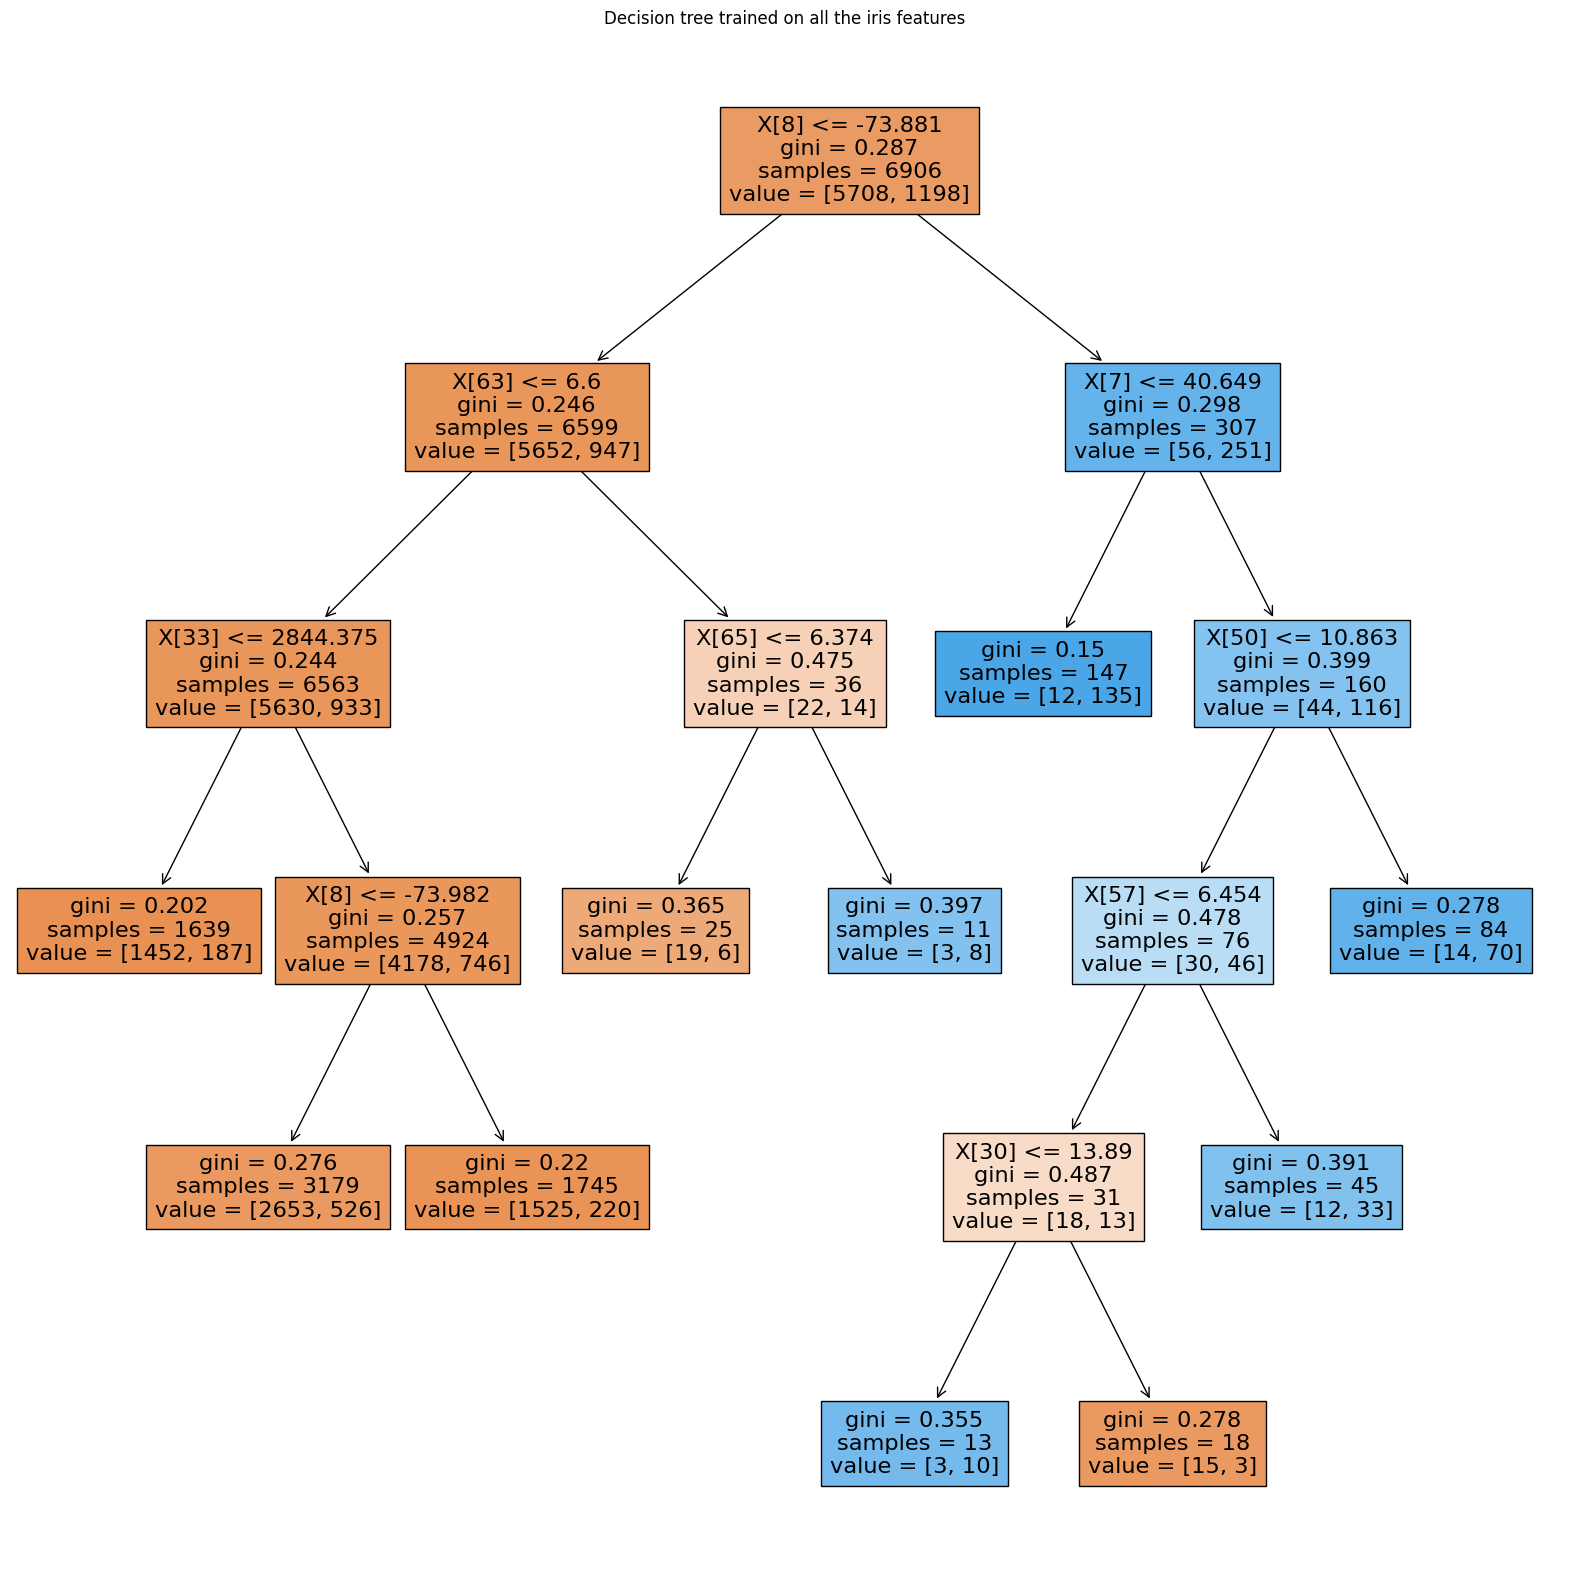

In [285]:
print(f'tree depth = {model.get_depth()}, number of leaf nodes = {model.get_n_leaves()}, params: {model.get_params()}')
print(f'feature_importance: {model.feature_importances_}')
# print name of feature with non-zero importance
important_fnames = []
for i, imp in enumerate(model.feature_importances_):
    if imp > 0:
        print(f'feature {i} {X_train.columns[i]} importance: {imp}')
        important_fnames.append(X_train.columns[i])


plt.figure(figsize=(20, 20))
plot_tree(model, filled=True)
plt.title("Decision tree trained on all the iris features")
plt.show()

In [286]:
def evaluate_model(model, xs, ys):
    y_predicted = model.predict(xs)

    accuracy = metrics.accuracy_score(ys, y_predicted)
    precision = metrics.precision_score(ys, y_predicted)
    recall = metrics.recall_score(ys,y_predicted)
    f1_score = metrics.f1_score(ys, y_predicted)


    print("--------------------------------------")
    # print('Accuracy is  {}'.format(accuracy))
    # print('Precision is {}'.format(precision))
    # print('Recall is    {}'.format(recall))
    # print('F1 score is  {}'.format(f1_score))
    # accuracy for each class
    print(metrics.classification_report(ys, y_predicted))
    print("--------------------------------------")
    return accuracy, precision, recall
print("The model performance for training set")
evaluate_model(model, X_train, y_train)
print("The model performance for testing set")
evaluate_model(model, X_test, y_test)

The model performance for training set
--------------------------------------
              precision    recall  f1-score   support

           0       0.86      0.99      0.92      5708
           1       0.85      0.21      0.34      1198

    accuracy                           0.86      6906
   macro avg       0.86      0.60      0.63      6906
weighted avg       0.86      0.86      0.82      6906

--------------------------------------
The model performance for testing set
--------------------------------------
              precision    recall  f1-score   support

           0       0.86      0.99      0.93      2500
           1       0.84      0.16      0.26       461

    accuracy                           0.86      2961
   macro avg       0.85      0.58      0.59      2961
weighted avg       0.86      0.86      0.82      2961

--------------------------------------


(0.8638973319824383, 0.8372093023255814, 0.1561822125813449)

In [287]:
y_predicted = model.predict(X_test)
# show percentage of different values
pd.Series(y_predicted).value_counts(normalize=True)

0    0.970956
1    0.029044
dtype: float64

## Train model with feature with non-zero importance

tree depth = 9, number of leaf nodes = 20, params: {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': 20, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 77, 'splitter': 'best'}
feature_importance: [0.05357357 0.82650579 0.01634815 0.01907189 0.01237992 0.01079365
 0.05050816 0.01081888]
feature 0 pickup_latitude importance: 0.053573567872061224
feature 1 pickup_longitude importance: 0.8265057906517995
feature 2 mean_1h_total_amount importance: 0.016348147965679394
feature 3 sum_1h_trip_distance importance: 0.019071887121468793
feature 4 std_168h_fare_amount importance: 0.012379918188733014
feature 5 var_1h_trip_distance importance: 0.010793649392374472
feature 6 var_1h_tip_amount importance: 0.05050815920302473
feature 7 var_168h_tip_amount importance: 0.010818879604858991


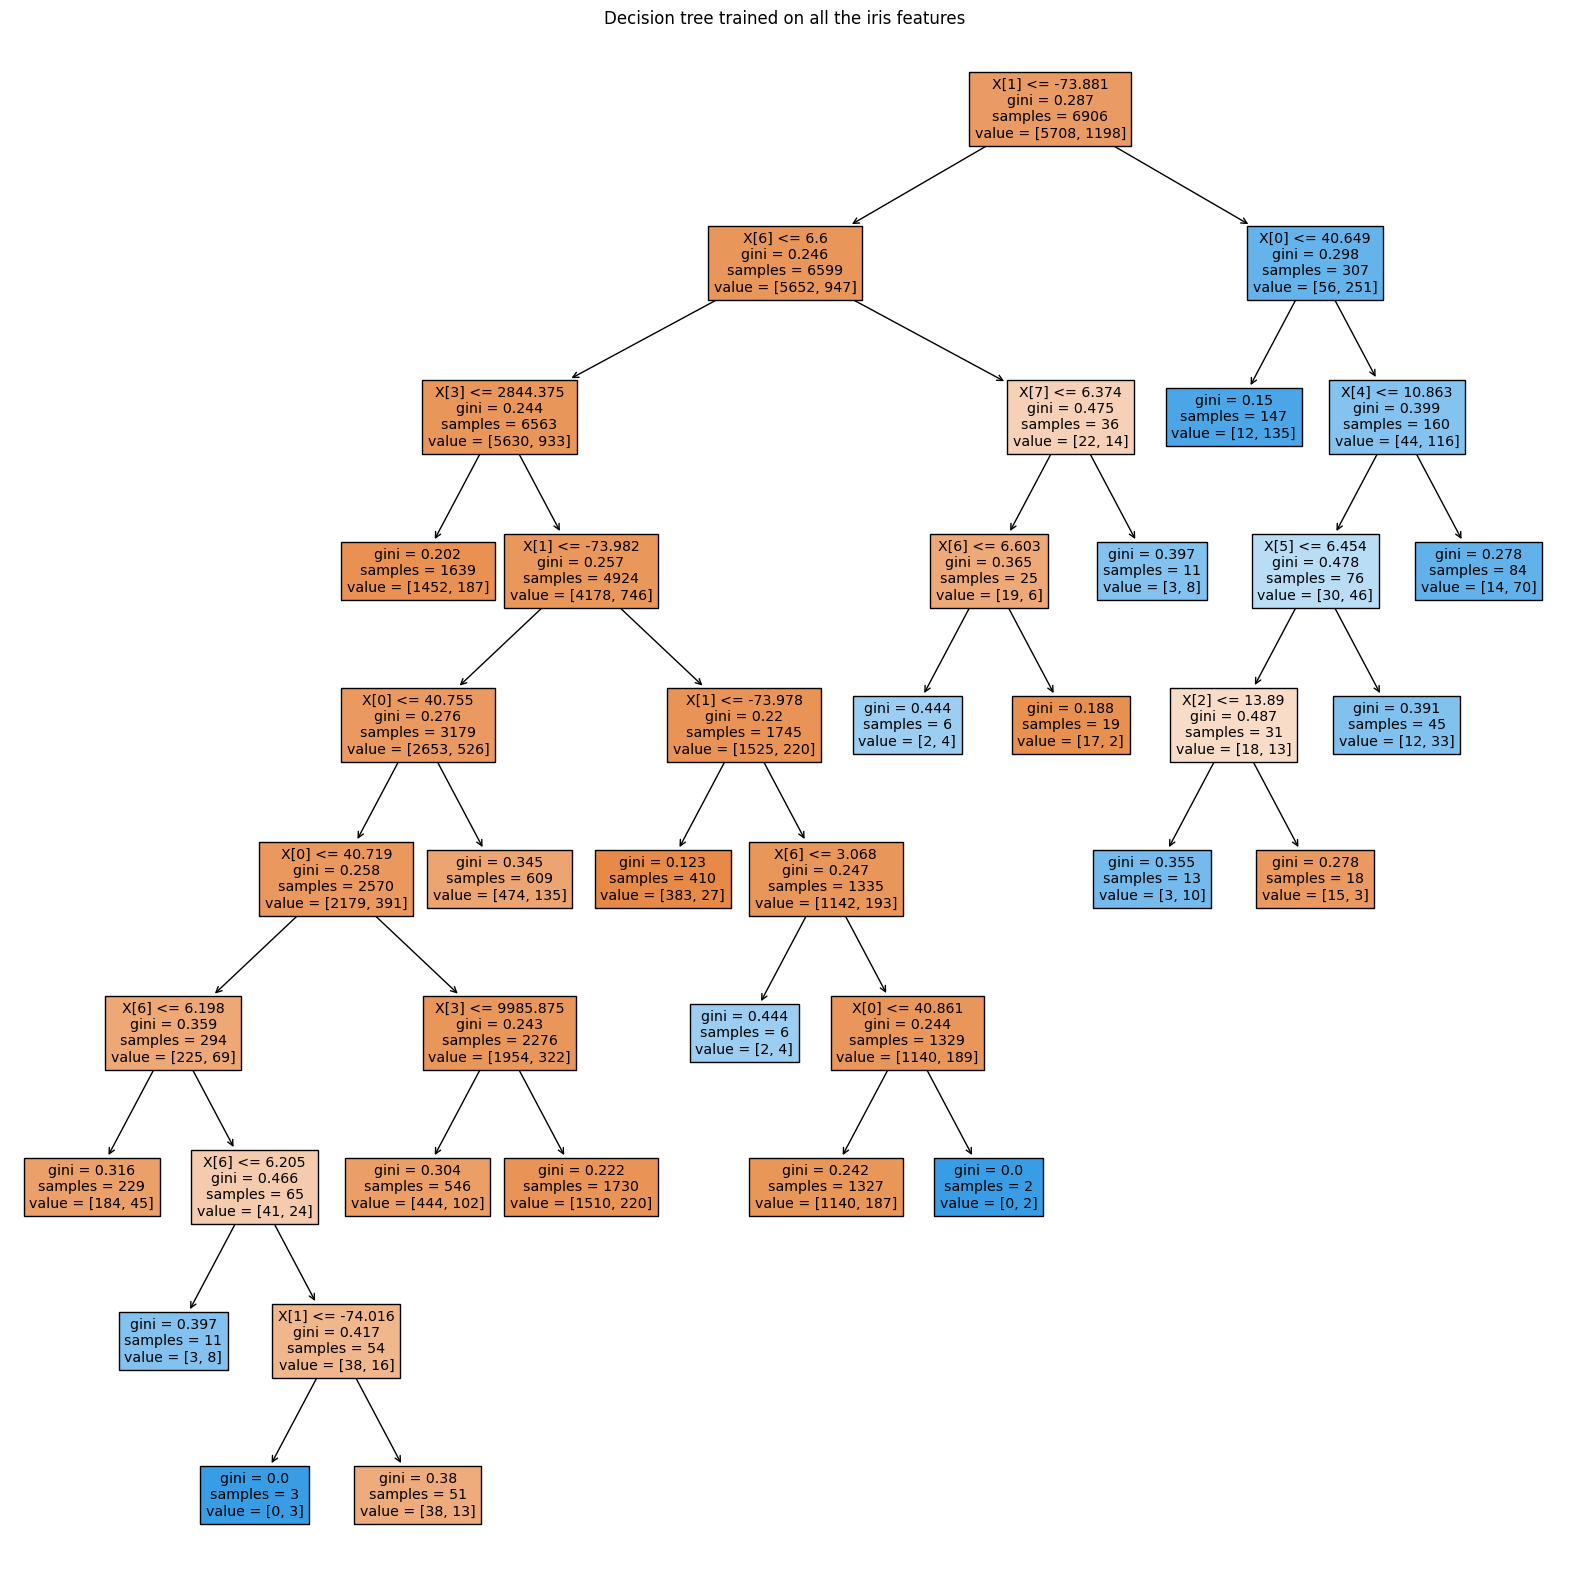

In [288]:
# important_fnames = [fname for fname in important_fnames if fname in agg_feature_names]
new_X_train = X_train[important_fnames]
new_X_test = X_test[important_fnames]

new_model = DecisionTreeClassifier(max_leaf_nodes=20, random_state=77)
new_model.fit(new_X_train, y_train)

print(f'tree depth = {new_model.get_depth()}, number of leaf nodes = {new_model.get_n_leaves()}, params: {new_model.get_params()}')
print(f'feature_importance: {new_model.feature_importances_}')
# print name of feature with non-zero importance
for i, imp in enumerate(new_model.feature_importances_):
    if imp > 0:
        print(f'feature {i} {new_X_train.columns[i]} importance: {imp}')

plt.figure(figsize=(20, 20))
plot_tree(new_model, filled=True)
plt.title("Decision tree trained on all the iris features")
plt.show()

In [289]:
print("The model performance for training set")
evaluate_model(new_model, new_X_train, y_train)
print("The model performance for testing set")
evaluate_model(new_model, new_X_test, y_test)

# show percentage of different values
pd.Series(new_model.predict(new_X_test)).value_counts(normalize=True)

The model performance for training set
--------------------------------------
              precision    recall  f1-score   support

           0       0.86      0.99      0.92      5708
           1       0.84      0.23      0.36      1198

    accuracy                           0.86      6906
   macro avg       0.85      0.61      0.64      6906
weighted avg       0.86      0.86      0.82      6906

--------------------------------------
The model performance for testing set
--------------------------------------
              precision    recall  f1-score   support

           0       0.86      0.99      0.92      2500
           1       0.82      0.16      0.26       461

    accuracy                           0.86      2961
   macro avg       0.84      0.57      0.59      2961
weighted avg       0.86      0.86      0.82      2961

--------------------------------------


0    0.97028
1    0.02972
dtype: float64

In [290]:
apx_df_raw_features = apx_df[selected_nonagg_features]
apx_df_agg_features = apx_df[selected_agg_features]
apx_df_features = apx_df_raw_features.join(apx_df_agg_features)
apx_X_train, apx_X_test, apx_y_train, apx_y_test = train_test_split(apx_df_features, df_target, test_size=0.3, shuffle=False)
apx_X_train = apx_X_train[important_fnames]
apx_X_test = apx_X_test[important_fnames]

In [291]:

print("The model performance for training set")
evaluate_model(new_model, apx_X_train, apx_y_train)
print("The model performance for testing set")
evaluate_model(new_model, apx_X_test, apx_y_test)

print("The model performance for training set to exact")
evaluate_model(new_model, apx_X_train, new_model.predict(new_X_train))
print("The model performance for testing set to exact")
evaluate_model(new_model, apx_X_test, new_model.predict(new_X_test))

# show percentage of different values
pd.Series(new_model.predict(apx_X_test)).value_counts(normalize=True)

The model performance for training set
--------------------------------------
              precision    recall  f1-score   support

           0       0.85      0.82      0.84      5708
           1       0.26      0.30      0.28      1198

    accuracy                           0.73      6906
   macro avg       0.56      0.56      0.56      6906
weighted avg       0.75      0.73      0.74      6906

--------------------------------------
The model performance for testing set
--------------------------------------
              precision    recall  f1-score   support

           0       0.87      0.83      0.85      2500
           1       0.25      0.31      0.27       461

    accuracy                           0.75      2961
   macro avg       0.56      0.57      0.56      2961
weighted avg       0.77      0.75      0.76      2961

--------------------------------------
The model performance for training set to exact
--------------------------------------
              precision   

0    0.808848
1    0.191152
dtype: float64

In [292]:
# train set
node_train = new_model.apply(new_X_train)
apx_node_train = new_model.apply(apx_X_train)
print(metrics.classification_report(apx_node_train, node_train))

# test set
node_test = new_model.apply(new_X_test)
apx_node_test = new_model.apply(apx_X_test)
print(metrics.classification_report(apx_node_test, node_test))

              precision    recall  f1-score   support

           3       1.00      1.00      1.00       147
           8       0.52      1.00      0.69        44
          10       0.00      0.00      0.00         0
          12       0.58      0.79      0.67        33
          13       0.62      0.80      0.70        10
          14       0.56      0.14      0.22        73
          15       0.68      1.00      0.81      1122
          20       1.00      0.91      0.95       672
          23       1.00      0.88      0.93       468
          25       1.00      0.01      0.01      1120
          27       1.00      0.71      0.83       324
          29       0.00      0.00      0.00         0
          31       0.00      0.00      0.00         0
          32       0.00      0.00      0.00         0
          33       0.60      0.17      0.27      1870
          34       0.24      0.65      0.35       635
          35       0.23      0.94      0.37       327
          36       0.50    

/home/ckchang/anaconda3/envs/amd/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ckchang/anaconda3/envs/amd/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ckchang/anaconda3/envs/amd/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ckchang/anaconda

In [293]:
tmp_X_train = new_X_train
tmp_X_test = new_X_test
for name in important_fnames:
    if name in agg_feature_names:
        default_value = X_train[name].mean()
        # default_value = 0
        print(f'feature {name} default value: {default_value}')
        tmp_X_train[name] = default_value
        tmp_X_test[name] = default_value
print("The model performance for training set")
evaluate_model(new_model, tmp_X_train, y_train)
print("The model performance for testing set")
evaluate_model(new_model, tmp_X_test, y_test)

print("The model performance for training set to exact")
evaluate_model(new_model, tmp_X_train, new_model.predict(new_X_train))
print("The model performance for testing set to exact")
evaluate_model(new_model, tmp_X_test, new_model.predict(new_X_test))


# train set
tmp_node_train = new_model.apply(tmp_X_train)
print(metrics.classification_report(tmp_node_train, node_train))

# test set
tmp_node_test = new_model.apply(tmp_X_test)
print(metrics.classification_report(tmp_node_test, node_test))

pd.Series(new_model.predict(tmp_X_train)).value_counts(normalize=True)

feature mean_1h_total_amount default value: 14.246496488089106
feature sum_1h_trip_distance default value: 7409.603781817702
feature std_168h_fare_amount default value: 11.17800411845234
feature var_1h_trip_distance default value: 6.350676527791116
feature var_1h_tip_amount default value: 4.872522539085075
feature var_168h_tip_amount default value: 6.4641447306162645
The model performance for training set
--------------------------------------
              precision    recall  f1-score   support

           0       0.86      0.99      0.92      5708
           1       0.82      0.21      0.34      1198

    accuracy                           0.86      6906
   macro avg       0.84      0.60      0.63      6906
weighted avg       0.85      0.86      0.82      6906

--------------------------------------
The model performance for testing set
--------------------------------------
              precision    recall  f1-score   support

           0       0.86      0.99      0.92      2500


/tmp/ipykernel_327206/735692828.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_X_train[name] = default_value
/tmp/ipykernel_327206/735692828.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_X_test[name] = default_value
/home/ckchang/anaconda3/envs/amd/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _war

0    0.955256
1    0.044744
dtype: float64